## Decision Tree

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/alexteboul/diabetes-health-indicators-dataset/versions/1


In [3]:
csv_path = os.path.join(path, "diabetes_binary_health_indicators_BRFSS2015.csv")
df = pd.read_csv(csv_path)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df = df.astype(int) # convert entire dataframe from float to int

In [5]:
df['sex']=df['sex'].map({0:'female',1:'male'})

In [6]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)
len(df_train),len(df_val),len(df_test)

(152208, 50736, 50736)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [8]:
y_train = df_train.diabetes_binary.values
y_val = df_val.diabetes_binary.values
y_test = df_test.diabetes_binary.values

In [9]:
del df_train['diabetes_binary']
del df_val['diabetes_binary']
del df_test['diabetes_binary']

In [10]:
dv = DictVectorizer(sparse=False)

In [11]:
train_dict = df_train.to_dict(orient='records')

In [12]:
X_train = dv.fit_transform(train_dict)

In [13]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [14]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [15]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.601281083790509

In [16]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9998991437275485

In [17]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.753351027190579
val: 0.7553592098077226


In [19]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- highbp <= 0.50
|   |--- genhlth <= 2.50
|   |   |--- class: 0
|   |--- genhlth >  2.50
|   |   |--- class: 0
|--- highbp >  0.50
|   |--- genhlth <= 2.50
|   |   |--- class: 0
|   |--- genhlth >  2.50
|   |   |--- class: 0



## Decision Tree Parameter Tuning

### Tune max_depth

In [20]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.689
   2 -> 0.755
   3 -> 0.784
   4 -> 0.798
   5 -> 0.809
   6 -> 0.815
  10 -> 0.810
  15 -> 0.721
  20 -> 0.641
None -> 0.600


### Tune min_samples_leafs

In [21]:
scores = []

for depth in [4, 5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [22]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth            4      5      6      10
min_samples_leaf                            
1                 0.798  0.809  0.815  0.810
5                 0.798  0.809  0.815  0.810
10                0.798  0.809  0.815  0.810
15                0.798  0.809  0.815  0.811
20                0.798  0.809  0.815  0.812
100               0.798  0.809  0.815  0.818
200               0.798  0.809  0.815  0.821
500               0.798  0.810  0.815  0.822

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

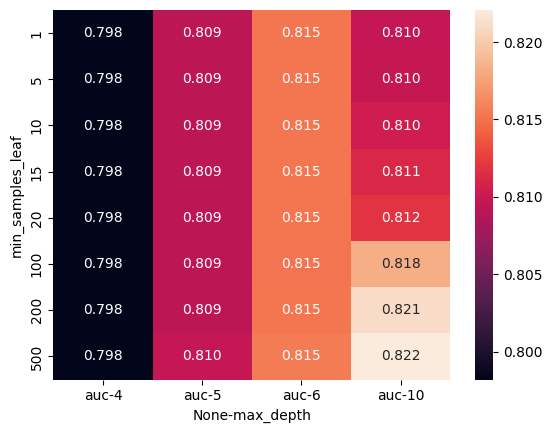

In [23]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [24]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=200)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,200
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

### Tune n_estimators ALONE

In [26]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [27]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

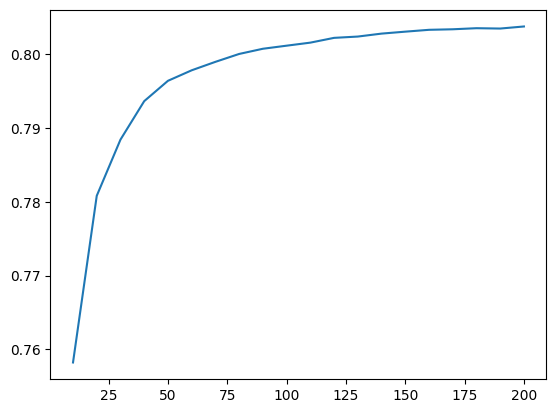

In [28]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [29]:
n_estimators=200

### Tune max_depth AND n_estimators together

In [30]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [31]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

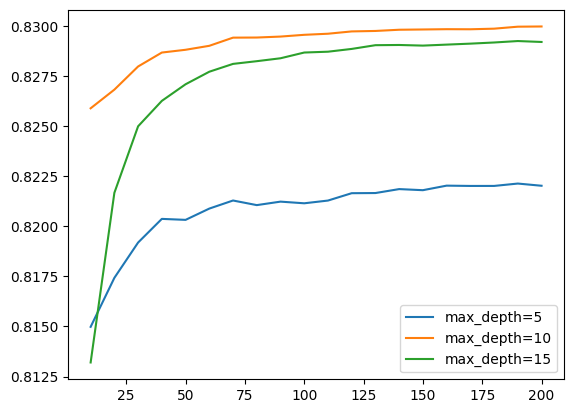

In [32]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

### Tune min_samples_leaf

In [33]:
max_depth = 10
scores = []

for s in tqdm([1, 3, 5, 10, 50]):
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth= 10,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

100%|████████████████████████████████████████████████████████████| 5/5 [13:08<00:00, 157.65s/it]


In [34]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

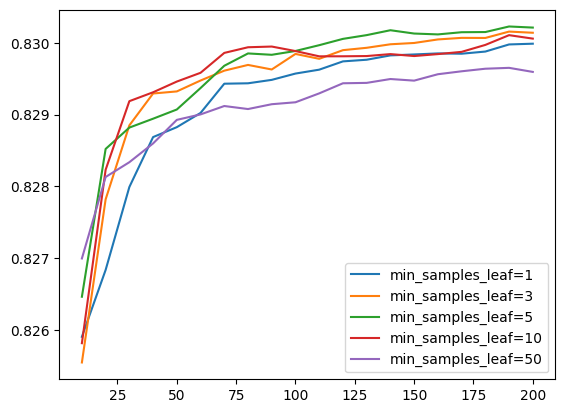

In [35]:
for s in [1, 3, 5, 10, 50]:
    
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [36]:
min_samples_leaf = 5

In [37]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth= 10,
                            min_samples_leaf= 5,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Save the model

In [38]:
import pickle

In [39]:
import pickle

output_file = 'rf_model.bin'

with open(output_file, 'wb') as f:
    pickle.dump((dv, rf), f)

Load the model

In [41]:
model_file = 'rf_model.bin'

with open(model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [42]:
dv,model

(DictVectorizer(sparse=False),
 RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                        random_state=1))

In [43]:
people = {
    'highbp':1,
    'highchol':0,
    'cholcheck':1,
    'bmi':38,
    'smoker':1,
    'stroke':0,
    'heartdiseaseorattack':0,
    'physactivity':1,
    'fruits':1,
    'veggies':1,
    'hvyalcoholconsump':0,
    'anyhealthcare':1,
    'nodocbccost':0,
    'genhlth':3,
    'menthlth':0,
    'physhlth':0,
    'diffwalk':0,
    'sex':'female',
    'age':12,
    'education':5,
    'income':8
}

In [45]:
X = dv.transform([people])

In [46]:
model.predict_proba(X)[0,1]

np.float64(0.26376121800054475)